## Overview

This notebook calculates and visualizes the following stats for a [medium.com](https://www.medium.com) publication:

   Publication statistics:
       - Views 
       - Reads 
       - Fans (formerly known as recommends) 
       - Fans/views ratio 

   Story statistics:
       - Views 
       - Reads 
       - Reads/views ratio
       - Total fans (formerly known as recommends)
       - Fans/views ratio 
        
   Author statistics:     
       - Total views
       - Total reads
       - Total fans (formerly known as recommends)
       - Average reads/views ratio
       - Average fans/views ratio 

   Tag statistics:     
       - Total views
       - Total reads
       - Total fans (formerly known as recommends)
       - Average reads/views ratio
       - Average fans/views ratio 

  The measures are defined as follows:
     - Views: Number of visitors who landed on the story page 
     - Reads: Number of visitors that have read the complete story (this is an estimate)
     - Fans: Number of visitors that clapped
     - Reads/views ratio (derived) average number of visitors that read the entire story (and not just part of it)
     - Fans/views ratio (derived) average number of visitors that clapped
     
     
> A higher value is better for all measures.

For illustrative purposes sample data for [IBM Watson Data Labs](https://medium.com/ibm-watson-data-lab) is included. To analyze your own publication data, follow the instructions in the next section.

### Customization

Create two comma separated value (CSV) files with the following data structures.

#### File 1:  post/story statistics, as reported by https://medium.com/YOUR_PUBLICATION_NAME_HERE/stats/stories
   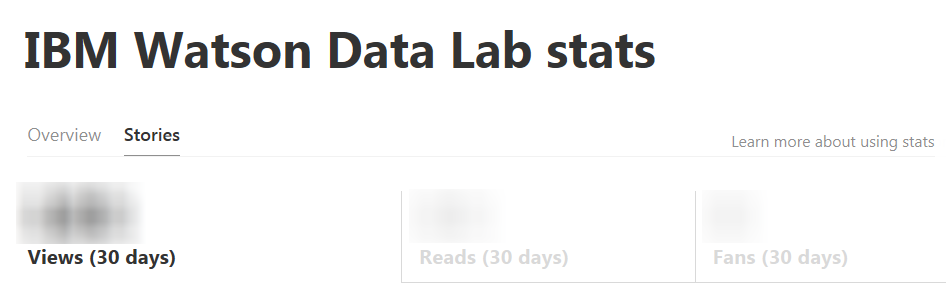
   * Header row (required): `title,publication-date,views,reads,read_ratio,fans`
   * Data types:
     * title: string
     * publication_month: formatted date string (YYYY-MM)
     * views: number<sup>*</sup>
     * reads: number<sup>*</sup>
     * read_ratio: number
     * fans: number<sup>*</sup>
     
     <sup>*</sup> valid number formats: `nn` (e.g. `123`) `n.nnK` (e.g. `2.4K` = 2400)
   * Sample stats data row: `"That one time I ...","2017-01",5.6K,2.8K,50,843`
   * Sample stats data: https://github.com/ibm-watson-data-lab/medium-publication-stats/blob/master/assets/stats.csv
   
#### File 2:  post/story metadata
   * Header row (required): `title,author,url,tags`
   * Data types:
     * title: string
     * author: string
     * url: post/story URL
     * tags: csv string `"tag1,tag2,...,tagN"`
   * Sample metadata row: "`That one time I ...","M\u00FCnchhausen","https://medium.com/made-up-adventures/...","horses,dragons,universe"`
   * Sample metadata: https://github.com/ibm-watson-data-lab/medium-publication-stats/blob/master/assets/metadata.csv
   
#### Upload the files to Object Storage or HTTP-accesible location  
This notebook can load csv files from the local file system, a remote location (e.g. a github repository) or Object Storage. Store the two files in the desired location.

#### Configure access to your files

In [ ]:
# @hidden_cell
# 
# TODO: Configure where to access the data set files
#

# Option 1:
# Load data sets from a local or remote source, accessible via the HTTP protocol
#

stats_csv_url = 'https://raw.githubusercontent.com/ibm-watson-data-lab/medium-publication-stats/master/assets/stats.csv'
meta_csv_url = 'https://raw.githubusercontent.com/ibm-watson-data-lab/medium-publication-stats/master/assets/metadata.csv'

# Option 2:
# Load data sets from Object Storage
#
os_credentials = {
  "auth_url": "https://identity.open.softlayer.com",
  "projectId": "",
  "region": "",
  "userId": "",
  "username": "",
  "password": "",
  "domainId": "",
  "domainName": ""    
}

# Object Storage container name
os_container_name = ''
# Stats file name
os_stats_csv_name = 'data.csv'
# Metadata file name
os_meta_csv_name = 'metadata.csv'

debug = False

In [ ]:
import IPython
import json
import pandas as pd
import pixiedust
import re
import requests
from datetime import datetime
from io import StringIO

In [ ]:
def isNotNoneOrEmpty(val):
    '''
        input: string value or None
        output: True if val is not None, is not an empty string or contains not only white spaces
    '''
    if val is None:
        return False
    else:
        return bool(val.strip())  
    return r

def isNoneOrEmpty(val):
    '''
        input: string value or None
        output: True if val is None an empty string or only contains white spaces
    '''
    return not isNotNoneOrEmpty(val)

def previewDF(df, name = 'variable', head = 5):
    '''
        input: df - Pandas DataFrame
        input: name - name of the DataFrame (optional) 
        input: head - number of rows to be displayed (default: 5)
    '''
    if isinstance(df, pd.DataFrame):
        shape = df.shape
        if len(shape) == 2:
            print '{} DataFrame dimensions: {} rows, {} columns'.format(name, shape[0], shape[1])
        else:
            print '{} DataFrame dimensions: {}'.format(name, shape)
        print '{} DataFrame preview:'.format(name)
        IPython.display.display(df.head(head))
    else:
        print 'Preview is not available because {} is not a Pandas DataFrame.'.format(name,"d")

def httpLoad(filename):
    '''
        input: csv file (utf-8 encoded) to be loaded
        output: Pandas DataFrame containing the input rows or None in case of an error 
    '''
    if isNotNoneOrEmpty(filename):
        r = requests.get(filename)
        if r.status_code == 200:
            df = pd.read_csv(filename, encoding='utf-8')
            print 'Loaded {} into DataFrame. Row count: {}'.format(filename, len(df.index))   
            return df
        else:
            print 'Error loading {}. HTTP status: {}'.format(filename, r.text)
            return None
    else:
        return None
    
def osLoad(credentials, container, filename, dtype = None):
    '''
        This function returns a StringIO object containing
        the file content from Bluemix Object Storage.
    '''
    if isNoneOrEmpty(container) or isNoneOrEmpty(filename):
        print 'Container or file name parameter is missing or empty.'
        return None

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domainId']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    if debug:
        print 'Sending authorization token request ...'
    try:
        resp1 = requests.post(url=url1, data=json.dumps(data), headers = headers1, timeout = 3)
    except Exception as e:
        print 'Error loading {}/{} from Object Storage. Authorization token request failed: {}. Check your credentials.'.format(container,filename, e)
        return None
    if resp1.status_code != 201:
        print 'Error loading {}/{} from Object Storage. Authorization token request failed: {}'.format(container,filename, resp1.text)
        return None
    else:    
        resp1_body = resp1.json()
        for e1 in resp1_body['token']['catalog']:
            if(e1['type']=='object-store'):
                for e2 in e1['endpoints']:
                            if(e2['interface']=='public'and e2['region']=='dallas'):
                                url2 = ''.join([e2['url'],'/', container, '/', filename])
        s_subject_token = resp1.headers['x-subject-token']
        headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
        if debug:
            print 'Sending file retrieval request ...'
        try: 
            resp2 = requests.get(url=url2, headers=headers2)
            if resp2.status_code != 200:
                raise Exception(resp2.status_code)
        except Exception as e:
            print 'Error loading {}/{} from Object Storage. File retrieval request failed with HTTP code {}. Check your credentials, container name and file name.'.format(container,filename, e)
            return None       
        
        return pd.read_csv(StringIO(resp2.text), encoding='utf-8', dtype = dtype)    

if isNotNoneOrEmpty(meta_csv_url) and isNotNoneOrEmpty(meta_csv_url):
    # load post stats     
    stats_df = httpLoad(stats_csv_url)
    # load post metadata
    meta_df = httpLoad(meta_csv_url)
else:
    # load post stats
    stats_df = osLoad(os_credentials, os_container_name, os_stats_csv_name)
    # load post metadata
    meta_df = osLoad(os_credentials, os_container_name, os_meta_csv_name)  

print ''
    
if stats_df is not None:
    previewDF(stats_df, 'stats_df', 2) 
if meta_df is not None:
    previewDF(meta_df, 'meta_df', 2) 

In [ ]:
stats_df

### Prepare for stats analysis

In [ ]:
# merge both DataFrames
input_df = stats_df.merge(meta_df, how = 'outer', on = 'title', indicator = True)

# identify and report missing data
def validation(row):
    '''
    input: data row
    output: True of the row is valid, False otherwise
    '''
    if row['_merge'] == 'left_only':
        # issue warning
        print u'Warning. Metadata are missing for row with title "{}"'.format(row['title'])
        return False
    elif row['_merge'] == 'right_only':
        # issue warning
        print u'Warning. Stats are missing for row with title "{}"'.format(row['title'])
        return False
    return True
# create analysis DataFrames, keeping only rows that contain stats and metadata
analysis_df = input_df[input_df.apply(validation, axis = 1)]
del analysis_df['_merge']

# enrich DataFrame
today = datetime.now().date()

# helper
def getYear(col):
    '''
        input: col - date expressed as 'YYYY-MM'
        output: YYYY
    '''    
    d = datetime.strptime(col, '%Y-%m').date()
    return d.year

# helper
def calcElapsed(col):
    '''
        input: col - date expressed as 'YYYY-MM'
        output: number of month since 'YYYY-MM', including current month (value is always > 0)
    '''
    d = datetime.strptime(col, '%Y-%m').date()
    return ((today.year - d.year) * 12 + today.month - d.month) + 1

# calculate for how many month a story has been published
analysis_df['duration'] = analysis_df['publication_month'].apply(calcElapsed)

# helper
def calcAvgInt(col1, col2):
    '''
        input: col1 - numeric column
        input: col2 - numeric column, > 0
        output: int(col1/col2)
    '''
    return int(col1/col2)

# extract year
analysis_df['publication_year'] = analysis_df['publication_month'].apply(lambda month: getYear(month))
# calculate average views per published month
analysis_df['avg_views'] = analysis_df.apply(lambda row: calcAvgInt(row['views'],row['duration']), axis=1)
# calculate average reads per published month
analysis_df['avg_reads'] = analysis_df.apply(lambda row: calcAvgInt(row['reads'],row['duration']), axis=1)
# calculate average number of fans per published month
analysis_df['avg_fans'] = analysis_df.apply(lambda row: calcAvgInt(row['fans'],row['duration']), axis=1)

# calculate fans/views ratio
analysis_df['fv_ratio'] = analysis_df['fans'] / analysis_df['views']

# calculate reads/views ratio
analysis_df['rv_ratio'] = analysis_df['reads'] / analysis_df['views']

previewDF(analysis_df, 'analysis_df') 

### Prepare for tag analysis

Create a DataFrame, containing the following columns:
 * `tag` - tag name 	
 * `count` - number of posts containing the tag
 * `views` - total number of visitors for posts containing the tag
 * `reads` - total number of reads for posts containing the tag
 * `fans` - total number of visitors who applauded posts containing the tag
 * `avg_views` - average number of views for posts containing the tag (`views` / `count`)
 * `avg_reads` - average number of reads for posts containing the tag (`reads` / `count`)
 * `avg_fans` - average number of fans for posts containing the tag (`fans` / `count`)
 * `rv_ratio` - reads/views ratio for posts containing the tag(`reads` / `views`)
 * `fv_ratio` - fans/views ratio for posts containing the tag (`fans` / `views`)
 * `url` - medium.com search url for the tag

In [ ]:
# create tag dataframe
tag_stats = {}
tag_associations = []
for row in analysis_df.itertuples():
    if row[11] is not None:
        for tag in row[9].split(','):
            tag = tag.strip()
            if tag in tag_stats:
                tag_stats[tag]['count'] += 1
                tag_stats[tag]['views'] += row[3]
                tag_stats[tag]['reads'] += row[4]
                tag_stats[tag]['fans'] += row[6]
            else:
                tag_stats[tag] = {
                                    'count': 1,
                                    'views': row[3],
                                    'reads': row[4],
                                    'fans': row[6],                         
                }
                
            tag_associations.append((tag, row[1], row[2], row[8]))     

tag_associations_df = pd.DataFrame(tag_associations, columns=['tag','title','publication_month', 'url'])

previewDF(tag_associations_df, 'tag_associations_df') 

# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.from_dict.html                
tag_analysis_df = pd.DataFrame.from_dict(tag_stats, orient='index').reset_index().rename(columns={"index": "tag"})

def calcAvgInt(col1, col2):
    return int(col1/col2)

tag_analysis_df['avg_views'] = tag_analysis_df.apply(lambda row: calcAvgInt(row['views'],row['count']), axis=1)
tag_analysis_df['avg_reads'] = tag_analysis_df.apply(lambda row: calcAvgInt(row['reads'],row['count']), axis=1)
tag_analysis_df['avg_fans'] = tag_analysis_df.apply(lambda row: calcAvgInt(row['fans'],row['count']), axis=1)

# calculate fans/views ratio for each tag
tag_analysis_df['fv_ratio'] = tag_analysis_df['fans'] / tag_analysis_df['reads']

# calculate reads/views ratio
tag_analysis_df['rv_ratio'] = tag_analysis_df['reads'] / tag_analysis_df['views']

# medium.com tag URL
tag_analysis_df['url'] = 'https://medium.com/search?q=' + tag_analysis_df['tag'].str.replace(' ','+')

previewDF(tag_analysis_df, 'tag_analysis_df') 

***
## Plot basic publication statistics

 - Stories per month
 - Reads/views correlation
 - Fans/views correlation
 - Total number of views/reads/fans grouped by story publication month

In [ ]:
analysis_df['count'] = 1

In [ ]:
# number of posts per month
display(analysis_df)

In [ ]:
# views/reads/fans per month
display(analysis_df)

Reads/views (RV) ratio: How many people who open a story page actually read the entire story? Refer to the RV story stats chart further down for details.

In [ ]:
# correlation between reads and views
display(analysis_df)

Fans/views (FV) ratio: How many people who viewed a story clapped? Refer to the FV story stats chart further down for details.

In [ ]:
# correlation between recommendations and reads
display(analysis_df)

***

## Post statistics

### Views, reads and fans

Identify how many people have viewed/read/liked a story:
 - Options > Values: views
 - Options > Values: reads (default)
 - Options > Values: fans

In [ ]:
# views/reads/fans per story
display(analysis_df)

### Conversion ratios

A higher value is better, with 0 indicatig that nobody read/liked a story (boo!) and 1 that everybody read/liked a story (yay!)

Example: 1 out of 10 readers recommend story "The secret to maximizing story recommendations."

Recap: 
 * Views represent the number of visitors that accessed a story page. 
 * Reads represent the approximate number of visitors that read the story.
 * Recommends represent the number of visitors that liked a story.
 
To display the ratios select 
 * `Options` > `Values` : `rv_ratio` or
 * `Options` > `Values` : `fv_ratio` (default)

In [ ]:
# fans/views or reads/views ratios
display(analysis_df)

***

## Author statistics

### Views/reads/fans for each author

To display the stats select one of these measures
 * `Options` > `Values` : `views`
 * `Options` > `Values` : `reads` (default)
 * `Options` > `Values` : `fans`
 
and the desired aggregation 

 * `Options` > `Aggregation` : `SUM` (default)
 * `Options` > `Aggregation` : `AVG` 

In [ ]:
# higher values are better 
display(analysis_df)

### Recommends/reads and reads/views ratios for each author

To display the ratios for each author select 
 * `Options` > `Values` : `rv_ratio` 
 * `Options` > `Values` : `fv_ratio` (default) 

In [ ]:
# recommendation ratio author (higher is better)
display(analysis_df)

***
## Tag statistics

Each story is associated with zero or more tags. For example, a story about PixieDust might be tagged using `Data Science`


### Tag frequencies


To display how frequently stories with a particular tag were viewed/read/recommended choose
 * `Options` > `Values` : `views` 
 * `Options` > `Values` : `avg_views` 
 * `Options` > `Values` : `reads` (default) 
 * `Options` > `Values` : `avg_reads` 
 * `Options` > `Values` : `fans` 
 * `Options` > `Values` : `avg_fans`
 
Example: Stories tagged with "ice cream" were read 5,000 times. Assuming that 10 sories were associated with the tag, the average reads is 500.

In [ ]:
display(tag_analysis_df)

### Fans/views and reads/views ratios for each tag

To display the ratios for each tag select 
 * `Options` > `Values` : `rv_ratio` 
 * `Options` > `Values` : `fv_ratio` (default) 

In [ ]:
display(tag_analysis_df)

### Tag/story associations

Identify stories that are associated with a particular tag

In [ ]:
tag = 'Data Science'
display(tag_associations_df[tag_associations_df['tag'] == tag])

### Related stories on medium.com

Explore other stories on medium.com that use the same tags.

In [ ]:
for row in tag_analysis_df.itertuples(): 
    print 'Stories tagged "' + row[1] + '": ' + row[11]